# Differential expression analysis of TMT labeled proteome data using Limma's moderated t-test, Volcano plot
## searched with MaxQuant v.1.6.10.43 with unitprot reviewed mouse DB, without isoforms, with PIF cutoff (0.75) and iBAQ calculation enabled

### Author: Konstantin Kahnert
### Date: 2020_09_10

After determining differentially expressed proteins using the moderated t-test of the LIMMA package, we visualize the results in a volcano plot.

In this script we will:

- create a volcano plot
- create a cluster map of the significant proteins

## Load required packages

In [1]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap
from scipy.stats import gaussian_kde
from adjustText import adjust_text

## Define required functions

In [2]:
def save_figure(fig, name, folder_output):

    # create new path name for saving the figure as pdf
    path_fig = folder_output + "\\" + name + ".pdf"

    # save figure
    plt.savefig(path_fig, bbox_inches="tight")

    # create new path name for saving the figure as png
    path_fig = folder_output + "\\" + name + ".png"

    # save figure
    plt.savefig(path_fig, bbox_inches="tight", dpi=600)

    return None

def plot_clustermap(df, how="short", title="Hierarchical Clustering"):
    """
    Takes data frame, applies hierarchical clustering to columns and plots the resulting clustermap with dendrogram

    input: pandas dataframe (all columns are plotted)
    title= str, title of the plot

    :return: figure
    """
    if how == "short":
        # plot clustermap
        fig = sns.clustermap(df, metric="correlation", cmap="bwr", z_score=0, dendrogram_ratio=(0.4, 0.2),
                             figsize=(8, 10))

        # remove y axis labels (protein names)
        plt.sca(fig.fig.axes[2])
        plt.yticks([])
        plt.ylabel("")

        # rotate x tick labels
        plt.xticks(rotation=45)

        # set title
        fig.ax_col_dendrogram.set_title(title, weight="bold")

    elif how == "long":
        # plot clustermap
        fig = sns.clustermap(df, metric="correlation", cmap="bwr", z_score=0, dendrogram_ratio=(0.4, 0.05),
                             figsize=(8, 48))

        # remove y axis labels (protein names)
        plt.sca(fig.fig.axes[2])
        # plt.yticks([])
        # plt.ylabel("")
        ax = plt.gca()
        ax.set_yticks(np.arange(len(df))+0.5)
        ax.set_yticklabels(df.index)
        ax.tick_params(axis='y', which='both', width= 0.5, length= 2, labelsize=5)
        plt.yticks(va="center")
        # rotate x tick labels
        plt.xticks(rotation=45)

        # set title
        fig.ax_col_dendrogram.set_title(title, weight="bold")

    else:
        raise ValueError("The parameter \"how\" can either be \"long\" or \"short\"")

    return fig


##  Specify significance cutoffs

In [3]:
q_cutoff = 0.05
fc_cutoff = 1.3
annotate = True

## Specify proteins to annotate

In [4]:
to_annotate = ["Hcn1", "Hcn4", "Ctgf", "Ltbp2", "Ltbp3", "Ltbp4", "Chrm2", "Ptprc", "S100a9", "Cd14"]

## Specify imput file location

In [5]:
path_ttest_results = r"E:\Data\Heart_failure_mice_CS\Sinus_node\Proteome\Analysis\canonical\w_PIF\03_diff_expr_analysis\df_proteingroups_log_median subtraction_norm _empBayes_pvals.csv"

## Set path for output

In [6]:
folder_output = "".join(re.findall("[^\\\\]+\\\\", path_ttest_results))

## Load file to pandas data frame

In [7]:
df_ttest = pd.read_csv(path_ttest_results, index_col=0)
df_ttest.head(5)

,logFC,t.ord,t.mod,p.ord,p.mod,q.ord,q.mod,df.r,df.0,s2.0,...,Potential.contaminant,id,Peptide.IDs,Peptide.is.razor,Mod..peptide.IDs,Evidence.IDs,MS.MS.IDs,Best.MS.MS,Oxidation..M..site.IDs,Oxidation..M..site.positions
index,,,,,,,,,,,,,,,,,,,,,
1,-0.287587,-2.533768,-2.628880,0.035049,0.023093,0.072469,0.053879,8,3.23412,0.024258,...,NaN,0,6069;8344;8870;13813;19817;31684;39687,True;True;True;True;True;True;True,6333;8706;9250;9251;14422;20662;33317;41657,17467;17468;24091;25559;25560;25561;25562;2556...,11890;16386;17364;17365;17366;17367;17368;2768...,11890;16386;17367;27682;38853;60572;75514,0,352
2,0.918486,6.011668,6.591583,0.000319,0.000035,0.022077,0.007165,8,3.23412,0.024258,...,NaN,2,8075,True,8429,23393,15915,15915,NaN,NaN
3,0.099500,0.502777,0.568031,0.628668,0.581189,0.351109,0.339814,8,3.23412,0.024258,...,NaN,3,6875;9957;9997;19846;21301;24900;30715;32041;3...,True;True;True;True;False;True;True;False;Fals...,7170;10392;10433;20691;22201;25922;32320;33686...,20019;20020;28865;28866;29007;56623;60447;6044...,13630;13631;19648;19649;19743;38911;41620;4162...,13630;19649;19743;38911;41621;48121;59030;6127...,NaN,NaN
4,0.097552,1.393732,1.230788,0.200895,0.243549,0.184901,0.205969,8,3.23412,0.024258,...,NaN,6,1341;5441;7396;8665;18925;19306;20141;20260;24...,True;True;True;True;True;True;True;True;True;T...,1410;5671;7705;9037;19738;20132;20991;21113;25...,4183;15524;21501;24914;54064;55057;57365;57366...,2828;10467;14620;16921;37137;37807;39463;39709...,2828;10467;14620;16921;37137;37807;39463;39709...,2,1
5,0.271825,0.953934,1.104074,0.368048,0.292648,0.259952,0.228082,8,3.23412,0.024258,...,NaN,7,23613,True,24599,66471,45851,45851,NaN,NaN


## Rename columns (replace . by space)

In [8]:
df_ttest.columns = df_ttest.columns.str.replace(".", " ")

C:\Users\zlj638\AppData\Local\Continuum\anaconda3\envs\MS_data_analysis_pipeline\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  """Entry point for launching an IPython kernel.


## Add -log10(p.mod) column

In [9]:
df_ttest["-log10(p mod)"] = df_ttest["p mod"].apply(np.log10).apply(np.negative)

## Add Protein column with first protein of Majority protein IDs column

In [10]:
df_ttest["Protein"] = df_ttest["Majority protein IDs"].apply(lambda x: x.split(";")[0])

## Add gene name column with first gene of gene names column

In [11]:
df_ttest["Gene name"] = df_ttest["Gene names"].apply(lambda x: str(x).split(";")[0])

## extract all proteins that should be annotated

In [12]:
df_annotate = df_ttest[df_ttest["Gene name"].isin(to_annotate)]

## Set gene names as index

In [13]:
df_ttest.set_index("Gene name", inplace=True)
df_annotate.set_index("Gene name", inplace=True)

## Calculate log2 fc cutoffs

In [14]:
log_fc_cutoff = np.log2(fc_cutoff)

## Get -log10 p-value cutoff (moderated largest moderated p value of subset q value> 0.05)

In [15]:
# get significant proteins based on q value cutoff
df_signif_q = df_ttest[df_ttest["q mod"] < q_cutoff]

# sort dataframe by q values and get p value of the protein with the highest q value
p_cutoff = df_signif_q.sort_values("q mod").iloc[-1, :]["p mod"]

# calculate -log10 p value cutoff
log_p_cutoff = -np.log10(p_cutoff)

## Get significant proteins

In [16]:
df_signif = df_signif_q[df_signif_q["logFC"].abs() > log_fc_cutoff]

## Split by positive and negatice fold change

In [17]:
df_signif_pos = df_signif[df_signif["logFC"] > 0]
df_signif_neg = df_signif[df_signif["logFC"] < 0]

## Get number of significant proteins

In [18]:
num_sign_up = len(df_signif_pos)
num_sign_down = len(df_signif_neg)
num_sign = num_sign_up + num_sign_down

## Save dataframe as xlsx file

In [19]:
with pd.ExcelWriter(path_ttest_results[:-4] + "_vp.xlsx") as writer:
    df_ttest.to_excel(writer, sheet_name='All', index=False)
    df_signif_q.to_excel(writer, sheet_name='q<0.05', index=False)
    df_signif.to_excel(writer, sheet_name='q<0.05+FC>1.3', index=False)
    df_signif_neg.to_excel(writer, sheet_name='signif. decreased', index=False)
    df_signif_pos.to_excel(writer, sheet_name='signif. increased', index=False)

# Volcano plot

## Create scatter plot with -log10(p-values) on Y axis and log2(difference) on X axis

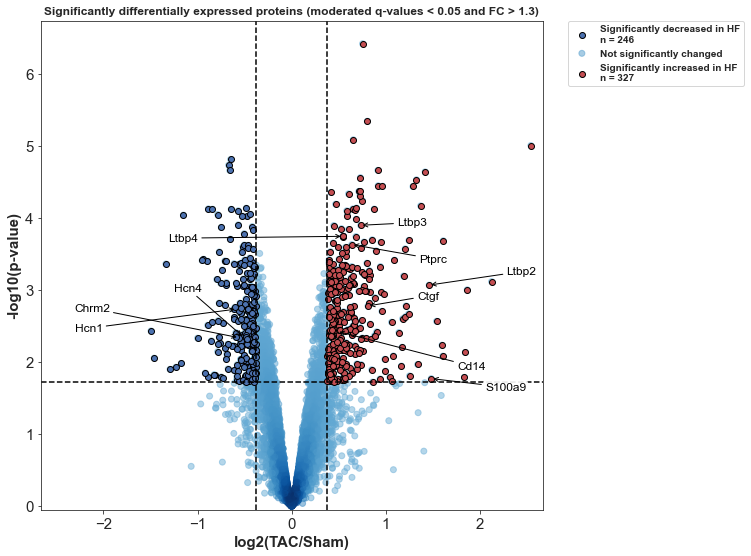

In [29]:
# Calculate the point density
xy = np.vstack([df_ttest["logFC"], df_ttest["-log10(p mod)"]])
z = gaussian_kde(xy)(xy)

# get blues colormap and reduce dynamic range (only go from medium dark to dark)
Blues = cm.get_cmap("Blues", 512)
Blues_new = ListedColormap(Blues(np.linspace(0.5, 1, 256)))

# set plot background to plain whit
sns.set_style("white")

# initiate new figure
fig, ax = plt.subplots(figsize=(9, 9))

# create scatter plot of all values colored by density (will be the seen for the unsignificant proteins later)
ax.scatter(x="logFC",
           y="-log10(p mod)",
           data=df_ttest,
           edgecolor=None,
           c=z,
           cmap=Blues_new,
           alpha=0.5,
           label="Not significantly changed")

# plot significant proteins with positive fold change in red on top of the density scatter plot
ax.scatter(x="logFC",
           y="-log10(p mod)",
           data=df_signif_pos,
           edgecolor="k",
           color="#C44E52",
           label="Significantly increased in HF\nn = " + str(num_sign_up))

# plot significant proteins with negative fold change in red on top of the density scatter plot
ax.scatter(x="logFC",
           y="-log10(p mod)",
           data=df_signif_neg,
           edgecolor="k",
           color="#4C72B0",
           label="Significantly decreased in HF\nn = " + str(num_sign_down))



# set axis limit
x_limit = max(abs(min(df_ttest["logFC"])), max(df_ttest["logFC"])) * 1.05
plt.xlim(-x_limit, x_limit)

y_limit_upper = df_ttest["-log10(p mod)"].max() * 1.05
y_limit_lower = -0.05
plt.ylim(y_limit_lower, y_limit_upper)

# draw line at p-value cutoff
plt.plot([-x_limit, x_limit], [log_p_cutoff, log_p_cutoff], linestyle="dashed", color="black")

# draw line for fold change cutoff
plt.plot([-log_fc_cutoff, -log_fc_cutoff], [-0.05, y_limit_upper], linestyle="dashed", color="black")
plt.plot([log_fc_cutoff, log_fc_cutoff], [-0.05, y_limit_upper], linestyle="dashed", color="black")

if annotate == True:
    # get texts for annotation
    texts = []
    for line in range(len(df_annotate)):
        texts.append(plt.text(df_annotate["logFC"][line], df_annotate["-log10(p mod)"][line],
                              df_annotate.index[line], horizontalalignment='left', size='large', color='black',
                              bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, pad=0.1)))

    # adjust text to avoid overlapping with arrows
    # adjust_text(texts, arrowprops=dict(arrowstyle='->', color='red'))

    # adjust text to avoid overlapping with arrows
    X = list(df_ttest["logFC"])
    Y = list(df_ttest["-log10(p mod)"])
    adjust_text(texts, x=X, y=Y, expand_points=(2, 2), expand_text=(3, 2), expand_align=(1.05, 1.2),
                force_text=0.5, force_points=0.5, precision=0.00001,
                arrowprops=dict(arrowstyle='->', color='black'))

else:
    pass

# get legend handelsa and labels
handles, labels = ax.get_legend_handles_labels()

# add axis labels
plt.xlabel("log2(TAC/Sham)", weight="bold", fontsize=15)
plt.ylabel("-log10(p-value)", weight="bold", fontsize=15)

# add tick marks
ax.tick_params(axis='both', which='major', direction="out", reset=True, right=False, top=False, labelsize=15)

# add title
plt.title("Significantly differentially expressed proteins (moderated q-values < 0.05 and FC > 1.3)", weight="bold")

# create legend stating number of significantly up and down as well as total number of diff. regulated proteins
legend_elements = [handles[2],
                   handles[0],
                   handles[1]]

ax.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.,
          prop={'size': 10, "weight": "bold"})

# save figure
name = "volcanoplot_limma"
save_figure(fig, name, folder_output)

# show figure
plt.show()

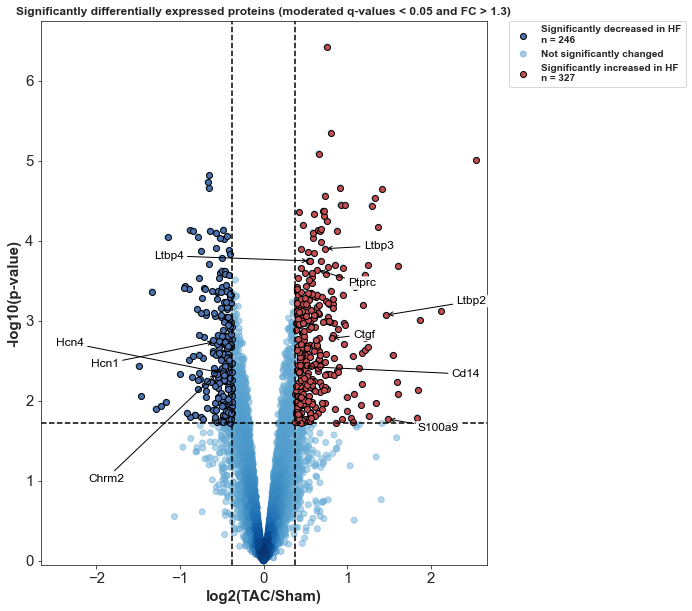

In [35]:
# Calculate the point density
xy = np.vstack([df_ttest["logFC"], df_ttest["-log10(p mod)"]])
z = gaussian_kde(xy)(xy)

# get blues colormap and reduce dynamic range (only go from medium dark to dark)
Blues = cm.get_cmap("Blues", 512)
Blues_new = ListedColormap(Blues(np.linspace(0.5, 1, 256)))

# set plot background to plain whit
sns.set_style("white")

# initiate new figure
fig, ax = plt.subplots(figsize=(8, 10))

# create scatter plot of all values colored by density (will be the seen for the unsignificant proteins later)
ax.scatter(x="logFC",
           y="-log10(p mod)",
           data=df_ttest,
           edgecolor=None,
           c=z,
           cmap=Blues_new,
           alpha=0.5,
           label="Not significantly changed")

# plot significant proteins with positive fold change in red on top of the density scatter plot
ax.scatter(x="logFC",
           y="-log10(p mod)",
           data=df_signif_pos,
           edgecolor="k",
           color="#C44E52",
           label="Significantly increased in HF\nn = " + str(num_sign_up))

# plot significant proteins with negative fold change in red on top of the density scatter plot
ax.scatter(x="logFC",
           y="-log10(p mod)",
           data=df_signif_neg,
           edgecolor="k",
           color="#4C72B0",
           label="Significantly decreased in HF\nn = " + str(num_sign_down))



# set axis limit
x_limit = max(abs(min(df_ttest["logFC"])), max(df_ttest["logFC"])) * 1.05
plt.xlim(-x_limit, x_limit)

y_limit_upper = df_ttest["-log10(p mod)"].max() * 1.05
y_limit_lower = -0.05
plt.ylim(y_limit_lower, y_limit_upper)

# draw line at p-value cutoff
plt.plot([-x_limit, x_limit], [log_p_cutoff, log_p_cutoff], linestyle="dashed", color="black")

# draw line for fold change cutoff
plt.plot([-log_fc_cutoff, -log_fc_cutoff], [-0.05, y_limit_upper], linestyle="dashed", color="black")
plt.plot([log_fc_cutoff, log_fc_cutoff], [-0.05, y_limit_upper], linestyle="dashed", color="black")

if annotate == True:
    # get texts for annotation
    texts = []
    for line in range(len(df_annotate)):
        texts.append(plt.text(df_annotate["logFC"][line], df_annotate["-log10(p mod)"][line],
                              df_annotate.index[line], horizontalalignment='left', size='large', color='black',
                              bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, pad=0.1)))

    # adjust text to avoid overlapping with arrows
    # adjust_text(texts, arrowprops=dict(arrowstyle='->', color='red'))

    # adjust text to avoid overlapping with arrows
    X = list(df_ttest["logFC"])
    Y = list(df_ttest["-log10(p mod)"])
    adjust_text(texts, x=X, y=Y, expand_points=(2, 2), expand_text=(3, 2), expand_align=(1.05, 1.2),
                force_text=0.5, force_points=0.5, precision=0.00001,
                arrowprops=dict(arrowstyle='->', color='black'))

else:
    pass

# get legend handelsa and labels
handles, labels = ax.get_legend_handles_labels()

# add axis labels
plt.xlabel("log2(TAC/Sham)", weight="bold", fontsize=15)
plt.ylabel("-log10(p-value)", weight="bold", fontsize=15)

# add tick marks
ax.tick_params(axis='both', which='major', direction="out", reset=True, right=False, top=False, labelsize=15)

# add title
plt.title("Significantly differentially expressed proteins (moderated q-values < 0.05 and FC > 1.3)", weight="bold")

# create legend stating number of significantly up and down as well as total number of diff. regulated proteins
legend_elements = [handles[2],
                   handles[0],
                   handles[1]]

ax.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.,
          prop={'size': 10, "weight": "bold"})

# save figure
name = "volcanoplot_limma"
save_figure(fig, name, folder_output)

# show figure
plt.show()

# Cluster map

In [50]:
# get normalized intensities of the significant proteins
df_signif_clustermap = df_signif.filter(regex="(TAC)|(Sham)")

df_signif_clustermap

,Sham 1,Sham 2,Sham 3,Sham 4,Sham 5,TAC 1,TAC 2,TAC 3,TAC 4,TAC 5
Gene name,,,,,,,,,,
Mpeg1,-3.555087,-3.724429,-3.816559,-3.800011,-3.702645,-2.315547,-2.786604,-3.141122,-3.053409,-2.709619
Mettl23,-2.651083,-2.115191,-2.797629,-2.941236,-2.373918,-2.849262,-2.963808,-3.205232,-2.875301,-3.129787
Kiaa1109,-0.441519,-0.273658,-0.520018,-0.692724,-0.696990,-1.131927,-1.136016,-0.734460,-0.664412,-0.923685
Nt5c1a,0.360371,0.469044,0.473901,0.274524,0.198794,-0.340935,-0.238859,0.274788,0.095864,-0.337144
Itih4,2.076217,2.330122,1.784573,1.813960,1.941264,2.672372,3.131243,2.915325,2.211060,2.900180
...,...,...,...,...,...,...,...,...,...,...
Fxyd1,1.863189,1.728282,1.899068,1.621464,1.431558,0.933558,1.345034,1.368185,1.553038,0.991017
Oasl2,-3.877649,-3.386984,-3.582248,-3.263348,-3.553322,-3.135165,-2.471718,-3.156421,-2.739006,-3.056381
Pck1,0.486089,-0.521824,0.556358,-0.372594,-0.008669,2.003492,1.765185,0.007938,0.310169,2.313373


## Plot clustermaps in a long and a short version

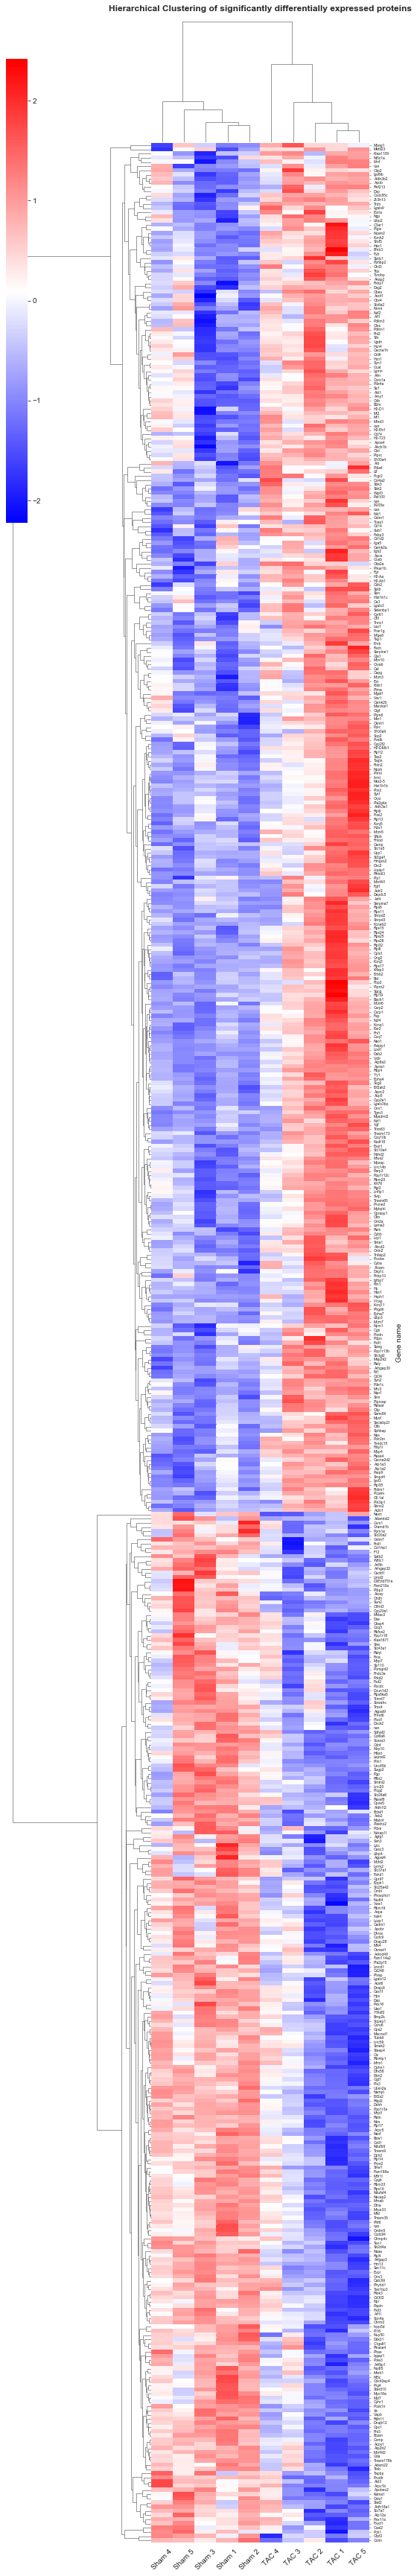

In [51]:
# plot clustermap of significant proteins
fig_clustermap = plot_clustermap(df_signif_clustermap, how="long",
                                 title="Hierarchical Clustering of significantly differentially expressed proteins")

# save figure
name = "clustermap_signif_FC_1.3_prot_limma_long"
save_figure(fig_clustermap, name, folder_output)

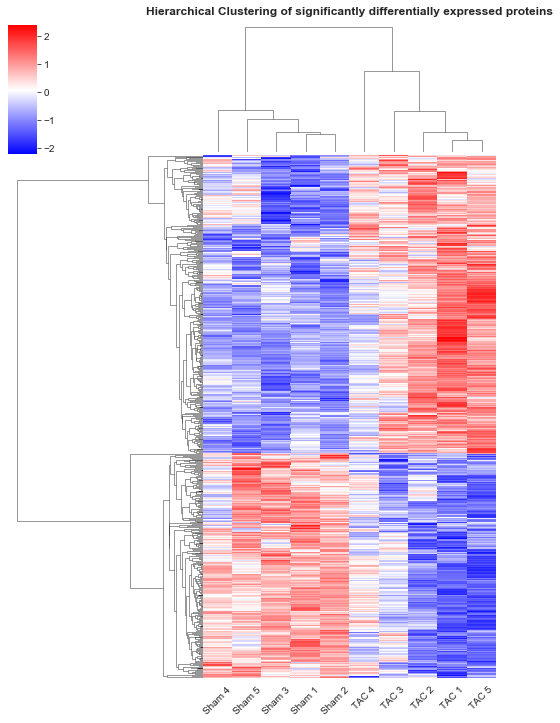

In [52]:
# plot clustermap of significant proteins
fig_clustermap = plot_clustermap(df_signif_clustermap, how="short",
                                 title="Hierarchical Clustering of significantly differentially expressed proteins")

# save figure
name = "clustermap_signif_FC_1.3_prot_limma_short"
save_figure(fig_clustermap, name, folder_output)